In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl
import sys
import pandas as pd

## On va résoudre l'équation de Vlasov-Poisson 1D x 1D  deux espèces :

### $$
    \begin{cases}
        \ \partial_{t}f_{i}(t,x,v) + v\partial_{x}f_{i}(t,x,v)+E(t,x)\partial_{v}f_{i}(t,x,v) = 0 \\  
        \ \partial_{t}f_{e}(t,x,v) + \frac{1}{\varepsilon}v\partial_{x}f_{e}(t,x,v)-\frac{1}{\varepsilon}E(t,x)\partial_{v}f_{e}(t,x,v) = 0 \\ 
        \ \partial_{x}E(t,x) =\int_{\mathbb{R}}f_{i}(t,x,v)-f_{e}(t,x,v)dv \ , avec  \ x \in [0,L] \ ,\  v\in [-8,8]
    \end{cases} 
   $$


Commençons par définir le maillage et l'initialisation

In [2]:
Nx =64
Nv =256
eps = 1
dt = 0.1
v0 = 2.4
L=21
A=0.01
sigma= 1/2
k =2.0*np.pi/L
xmin = 0.0
xmax =L
vmin = -8.0
vmax = 8.0
dx=(xmax-xmin)/Nx
dv=(vmax-vmin)/Nv
meshx=xmin+dx*np.arange(Nx)
meshv=vmin+dv*np.arange(Nv)
x,v = np.meshgrid(meshx,meshv)


### Fonctions initiale:

### $$
\begin{cases}
         f_{i}(t=0,x,v)= \frac{v^{2}}{\sqrt{2\pi} \sigma ^{3}}e^{\frac{-v^{2}}{2\sigma ^{2}}}(1+Acos(kx)) \\  
         f_{e}(t=0,x,v)= \frac{1}{\sqrt{2\pi}}e^{\frac{-v^{2}}{2}} 
\end{cases}  
$$


In [3]:
def fun_landau(x,v,choix_test):
    if(choix_test==1):
        return (v**2/(np.sqrt(2.0*np.pi)*(sigma)**3))*np.exp(-v**2/(2*(sigma)**2))*(1 + A*np.cos(k*x))
    elif(choix_test==2):
        return (1.0/np.sqrt(2.0*np.pi))*np.exp(-v**2/2.0)

In [4]:
choix_test=2
f0 = fun_landau(x,v,choix_test)

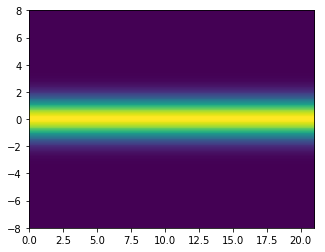

In [5]:
im = pl.imshow(f0,extent=(xmin,xmax,vmin,vmax),origin='lower')

In [6]:
def advect1d(p,f_new,f_old,a,L,dt):
    npts = np.size(f_old)
    n = npts
    x = -a*dt/L
    i0 = np.floor(x)
    alpha = x-i0
    for i in range(n):
        jn1 = int(i0+i-1)%n
        j = int(i0+i)%n
        jp1 = int(i0+i+1)%n
        jp2 = int(i0+i+2)%n
        L_n1=-alpha*(alpha-1)*(alpha-2)/6
        L_0=(alpha+1)*(alpha-1)*(alpha-2)/2
        L_1=-alpha*(alpha+1)*(alpha-2)/2
        L_2=alpha*(alpha-1)*(alpha+1)/6
        if (p==1):
             # une interpolation de degré 1
            f_new[i]=alpha*f_old[jp1] +(1-alpha)*f_old[j]
        elif (p==3):
            # une interpolation de degré 3
            f_new[i]=L_n1*f_old[jn1] +L_0*f_old[j]+L_1*f_old[jp1]+L_2*f_old[jp2] 
    return f_new  

In [7]:
def advect_x(f,a,dt,dx,p):
    npts_x = np.size(f,1)
    npts_v = np.size(f,0)
    f1d_old = np.zeros(npts_x)
    f1d_new = np.zeros(npts_x)
    if(np.size(a)!=npts_v):
        print("bad size for a")
        sys.exit()
    for j in range(npts_v):
        f1d_old = f[j,:]
        advect1d(p,f1d_new,f1d_old,a[j],dx,dt)
        f[j,:]=f1d_new
    return f   

In [8]:
def champ_E(f,dv,xmax,xmin):
    nx =np.size(f,1)
    rho = (dv)*np.sum(f,axis=0)
    modes = 2*np.pi*np.arange(nx/2+1)/(xmax-xmin)
    rhok = np.fft.rfft(rho)
    modes[0] = 1.  # avoid division by 0
    Z = np.real(np.fft.irfft(-1j*rhok/modes))
    return Z

In [9]:
def advect_v(f,E,dv,dt,p):
    npts_x = np.size(f,1)
    npts_v = np.size(f,0)
    f1d_old = np.zeros(npts_v)
    f1d_new = np.zeros(npts_v)
    if(np.size(E)!=npts_x):
        print("bad size for a")
        sys.exit()  
    for i in range(npts_x):
        f1d_old = f[:,i]
        #advection1D
        advect1d(p,f1d_new,f1d_old,E[i],dv,dt)
        f[:,i] = f1d_new
    return f

In [10]:
def normeL2(h,U):
    return np.sqrt(h*np.sum(U**2))

#### vérification de code problèmes Vlasov-Poisson 1D x 1D  deux espèces
###### Algorithme
- initilisation
on calcul $\rho(x,0)=\int_{\mathbb{R}}f_{ions}(t=0,x,v)-f_{electrons}(t=0,x,v)dv$,puit en clacul le champ électrique $E(x,0)$

- Passage de $t_{n}$ à $t_{n+1}$:

- On calcul $f_{ions}$ et $f_{electrons}$ sur un demi pas de temps $\frac{\Delta t}{2}$ en résolvant 

$$\partial_{t}f_{ions}(t,x,v)+E^{n}(t,x)\partial_{v}f_{ions}(t,x,v) = 0 $$ et$$\partial_{t}f_{electrons}(t,x,v)-\frac{1}{\varepsilon}E^{n}(t,x)\partial_{v}f_{electrons}(t,x,v) = 0 $$  par la méthode semi-lagrangienne.

- En suite on en retrouve $f_{ions}$ et $f_{electrons}$ sur un pas de temps $\Delta t$ en résolvant $$\partial_{t}f_{electrons}(t,x,v) + \frac{1}{\varepsilon}v\partial_{x}f_{electrons}(t,x,v) = 0 $$ et$$\partial_{t}f_{ions}(t,x,v) + v\partial_{x}f_{ions}(t,x,v) = 0 $$ par la méthode semi-lagrangienne.

- Et on calcul $\rho^{n+1}(x)=\int_{\mathbb{R}}f_{ions}(t,x,v)-f_{electrons}(t,x,v)dv$ , puis on calcule le champ électrique $E^{n+1}$ on résolvant Poisson.

- Et en fin on retourne  $f_{ions}^{n+1}$ et $f_{electrons}^{n+1}$  en résolvant sur un demi pas de temps  $\frac{\Delta t}{2}$ 
$$\partial_{t}f_{ions}(t,x,v)+E^{n}(t,x)\partial_{v}f_{ions}(t,x,v) = 0 $$ et$$\partial_{t}f_{electrons}(t,x,v)-\frac{1}{\varepsilon}E^{n}(t,x)\partial_{v}f_{electrons}(t,x,v) = 0 $$ .


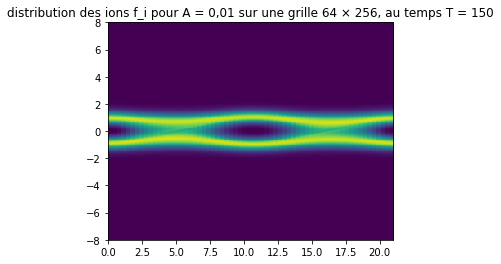

In [11]:
p=3
f_i=(v**2/(np.sqrt(2.0*np.pi)*(sigma)**3))*np.exp(-v**2/(2*(sigma)**2))*(1 + A*np.cos(k*x))
f_e=(1.0/np.sqrt(2.0*np.pi))*np.exp(-v**2/2.0)
f0=f_i-f_e
f = f0.copy()
E=champ_E(f,dv,xmax,xmin)
pl.title('distribution des ions f_i pour A = 0,01 sur une grille 64 × 256, au temps T = 150')
im = pl.imshow(f_i,extent=(xmin,xmax,vmin,vmax),origin='lower')
nr = 1500
l3_f =np.zeros(nr+1)
l3_f[0] =np.sqrt(1/(xmax))*normeL2(dx,E)
for n in range(nr):
    f_i=advect_v(f_i,E,dv,0.5*dt,p)
    f_e=advect_v(f_e,-E/eps,dv,0.5*dt,p)
    f_i=advect_x(f_i,meshv,dt,dx,p)
    f_e=advect_x(f_e,meshv/eps,dt,dx,p)
    f=f_i-f_e
    E=champ_E(f,dv,xmax,xmin)
    f_i=advect_v(f_i,E,dv,0.5*dt,p)
    f_e=advect_v(f_e,-E/eps,dv,0.5*dt,p)
    l3_f[n+1] =np.sqrt(1/(xmax))*normeL2(dx,E)
im.set_data(f_i)
im.set_array(f_i)    

##### L’énergie électrique théorique

L'expression de premier mode théorique:
$$\varepsilon_{1}=A|-0.1e^{0.089t}-6.9e^{1.5t}|$$
L'expression analytique  pour le second mode de Fourier:
$$\varepsilon_{2}=A^{2}(0.3e^{0.178t}+0.7e^{0.145t})$$
L’énergie électrique théorique est alors donnée par :
$$\sqrt{\varepsilon_{1}^{2}+\varepsilon_{2}^{2}}$$

In [12]:
def theorique_mode(A,t):
    E1=A*np.abs(-0.1*np.exp(0.089*t)-6.9*np.cos(1.5*t))
    E2=A**2*(0.3*np.exp(2*0.089*t)+0.7*np.exp(0.145*t))
    return np.sqrt(E1**2+E2**2)


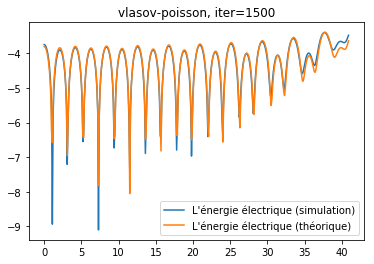

In [13]:
time = dt*np.arange(nr+1)
imin=0
imax=410
TM=theorique_mode(A,time)
pl.title('vlasov-poisson, iter='+str(n+1))
pl.plot(time[imin:imax],np.log(l3_f[imin:imax]),label="L'énergie électrique (simulation)")
pl.plot(time[imin:imax],np.log((1/np.pi)*TM[imin:imax]),label="L'énergie électrique (théorique)")
plt.legend()
plt.show()